# Variational Autoencoder

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/vae.jl

In [1]:
using Flux
using CuArrays
using Images
using Statistics
using Plots
using Plots.PlotMeasures
import Random: seed!

CuArrays.allowscalar(false)

pyplot()

┌ Warning: Incompatibility detected between CUDA and LLVM 8.0+; disabling debug info emission for CUDA kernels
└ @ CUDAnative /home/cavani/Workspace/julia-abc/software/julia-env/packages/CUDAnative/hfulr/src/CUDAnative.jl:114


Plots.PyPlotBackend()

In [2]:
# Load data, binarise it, and partition into mini-batches of M.

import Flux.Data.MNIST

function load_mnist_binary(split_name; use_gpu=true)
    X = float.(hcat(vec.(MNIST.images(split_name))...)) .> 0.5
    if use_gpu
        X = gpu(X)
    end
    return X
end

function make_batches(X, batch_size)
    num_examples = size(X, 2)
    data = [X[:, i] for i in Iterators.partition(1:num_examples, batch_size)]
    return data
end

X = load_mnist_binary(:train)
X_eval = load_mnist_binary(:test)
M = 100
train_data = make_batches(X, M)
eval_data = make_batches(X_eval, M)

┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/cavani/Workspace/julia-abc/software/julia-env/packages/Flux/NpkMm/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/cavani/Workspace/julia-abc/software/julia-env/packages/Flux/NpkMm/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/cavani/Workspace/julia-abc/software/julia-env/packages/Flux/NpkMm/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/cavani/Workspace/julia-abc/software/julia-env/packages/Flux/NpkMm/src/data/mnist.jl:24
┌ Info: Building the CUDAnative run-time library for your sm_35 device, this might take a while...
└ @ CUDAnative /home/cavani/Workspace/julia-abc/software/julia-env/packages/CUDAnative/hfulr/src/compiler/rtlib.jl:188


100-element Array{CuArray{Float32,2,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0

In [3]:
size(X)

(784, 60000)

In [4]:
length(train_data)

600

In [5]:
size(train_data[1])

(784, 100)

In [6]:
size(train_data[end])

(784, 100)

In [7]:
function sample_X(X, sample_size)
    indices = rand(1:size(X, 2), sample_size)
    X̃ = X[:, indices]
    return X̃
end

X̃ = sample_X(X, 10)

784×10 CuArray{Float32,2,Nothing}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.

In [8]:
################################# Define Model #################################

import Flux: functor

e = Float32(ℯ)

# Components of recognition model / "encoder" MLP.
struct Encoder
    A
    μ
    logσ
end

functor(g::Encoder) = (g.A, g.μ, g.logσ), y -> Encoder(y...)

function (g::Encoder)(X)
    A, μ, logσ = g.A, g.μ, g.logσ
    h = A(X)
    return μ(h), logσ(h)
end

function make_encoder(example_size, hidden_size, encoded_size; use_gpu=true)
    A = Dense(example_size, hidden_size, tanh)
    μ = Dense(hidden_size, encoded_size)
    logσ = Dense(hidden_size, encoded_size)
    
    if use_gpu
        A = gpu(A)
        μ = gpu(μ)
        logσ = gpu(logσ)
    end
    
    encoder = Encoder(A, μ, logσ)
    
    return encoder
end

# Generative model / "decoder" MLP.
function make_decoder(example_size, hidden_size, encoded_size; use_gpu=true)
    decoder = Chain(
        Dense(encoded_size, hidden_size, tanh),
        Dense(hidden_size, example_size, σ)
    )
    
    if use_gpu
        decoder = gpu(decoder)
    end
    
    return decoder
end

function z(μ, logσ; use_gpu=true)
    noise = randn(Float32, size(logσ)...)
    if use_gpu
        noise = gpu(noise)
    end
    return μ + (e .^ logσ) .* noise
end

# Image size, Latent dimensionality, # hidden units.
Dx = 28 ^ 2
Dh = 500
Dz = 5

g = make_encoder(Dx, Dh, Dz)
f = make_decoder(Dx, Dh, Dz);

In [9]:
θg = params(g)

for (i, θg′) in enumerate(θg)
    println(i, " : ", size(θg′))
end

1 : (500, 784)
2 : (500,)
3 : (5, 500)
4 : (5,)
5 : (5, 500)
6 : (5,)


In [10]:
θf = params(f)

for (i, θf′) in enumerate(θf)
    println(i, " : ", size(θf′))
end

1 : (500, 5)
2 : (500,)
3 : (784, 500)
4 : (784,)


In [11]:
x₁ = train_data[1]
μ₁, logσ₁ = g(x₁)

println("x₁    : ", size(x₁))
println("μ₁    : ", size(μ₁))
println("logσ₁ : ", size(logσ₁))

x₁    : (784, 100)
μ₁    : (5, 100)
logσ₁ : (5, 100)


In [12]:
z₁ = z(μ₁, logσ₁)

println("z₁    : ", size(z₁))

z₁    : (5, 100)


In [13]:
x₁′ = f(z₁)

println("x₁′   : ", size(x₁′))

x₁′   : (784, 100)


In [14]:
mse₁ = Flux.mse(x₁′, x₁)

println(mse₁)

0.2517066


In [15]:
####################### Define ways of doing things with the model. #######################

import Flux: binarycrossentropy

# log p(x|z) - conditional probability of data given latents.
log_p_x_z(x, z) = -sum(binarycrossentropy.(f(z), x))

# KL-divergence between approximation posterior and N(0, 1) prior.
kl_q_p(μ, logσ) = 0.5f0 * sum(e .^ (2f0 .* logσ) + μ .^ 2 .- 1f0 .- (2 .* logσ))

# Monte Carlo estimator of mean ELBO using M samples.
function L̄(X)
    μ′, logσ′ = g(X)
    z′ = z(μ′, logσ′)
    (log_p_x_z(X, z′) - kl_q_p(μ′, logσ′)) * 1 // M
end

seed!(42)
g = make_encoder(Dx, Dh, Dz)
f = make_decoder(Dx, Dh, Dz)
X̃ = sample_X(X, M)

-L̄(X̃) # 548.37317f0

548.37317f0

In [16]:
################################# Learn Parameters ##############################

import Flux: train!
import BSON: bson

θ = params(g, f)
optimizer = ADAM()
L2_f() = sum(x->sum(x .^ 2), params(f))
loss(X) = -L̄(X) + 0.01f0 * L2_f()

num_epochs = 200
early_stopping_patience = 10
learning_rate_schedule = 5

best_loss = nothing
last_improvement = 0
epoch_train_loss = Float32[]
epoch_eval_loss = Float32[]

for epoch_idx in 1:num_epochs
    println("Epoch ", epoch_idx)

    @time train!(loss, θ, zip(train_data), optimizer)

    train_loss = mean([-L̄(x) for x in train_data])
    eval_loss = mean([-L̄(x) for x in eval_data])
    push!(epoch_train_loss, train_loss)
    push!(epoch_eval_loss, eval_loss)
    println("Train Loss : ", round(train_loss; digits=4))
    println("Eval Loss  : ", round(eval_loss; digits=4))
    
    # If this is the best metric we've seen so far, save the model out
    if best_loss === nothing || eval_loss ≤ best_loss
        println(" -> New best loss! Saving model out to vae_mnist.bson")
        bson("vae_mnist.bson",
            encoder   = cpu(g),
            decoder   = cpu(f),
            epoch     = epoch_idx,
            loss      = train_loss,
            eval_loss = eval_loss
        )
        best_loss = eval_loss
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in N epochs, drop our learning rate:
    if epoch_idx - last_improvement ≥ learning_rate_schedule && optimizer.eta > 1e-6
        optimizer.eta /= 10.0
        println(" -> Haven't improved in a while, dropping learning rate to $(optimizer.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement ≥ early_stopping_patience
        println(" -> We're calling this converged.")
        break
    end
    
    println()
end

Epoch 1
 60.234769 seconds (73.96 M allocations: 3.582 GiB, 2.30% gc time)
Train Loss : 161.7681
Eval Loss  : 160.8458
 -> New best loss! Saving model out to vae_mnist.bson

Epoch 2
 10.363442 seconds (6.01 M allocations: 234.790 MiB, 1.34% gc time)
Train Loss : 150.0963
Eval Loss  : 149.1542
 -> New best loss! Saving model out to vae_mnist.bson

Epoch 3
 10.309282 seconds (6.01 M allocations: 234.119 MiB, 1.28% gc time)
Train Loss : 143.7455
Eval Loss  : 143.0081
 -> New best loss! Saving model out to vae_mnist.bson

Epoch 4
 10.308355 seconds (6.01 M allocations: 234.773 MiB, 1.30% gc time)
Train Loss : 140.247
Eval Loss  : 139.6708
 -> New best loss! Saving model out to vae_mnist.bson

Epoch 5
 10.306472 seconds (6.01 M allocations: 234.785 MiB, 1.38% gc time)
Train Loss : 137.2818
Eval Loss  : 136.8394
 -> New best loss! Saving model out to vae_mnist.bson

Epoch 6
 10.383645 seconds (6.01 M allocations: 234.052 MiB, 1.41% gc time)
Train Loss : 134.4889
Eval Loss  : 134.0652
 -> New

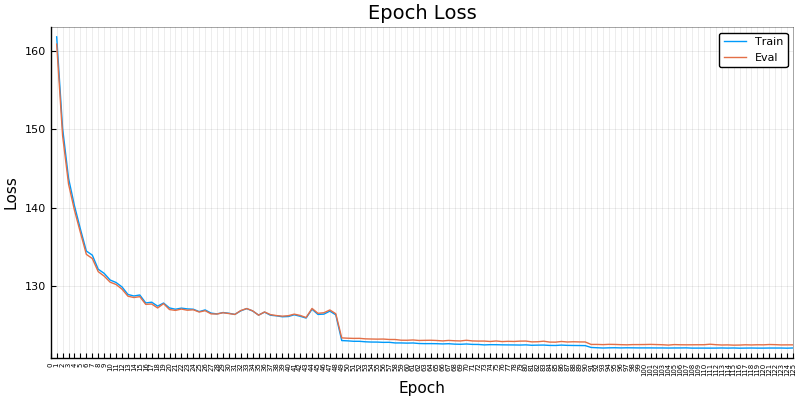

In [17]:
function plot_loss(log; fig_size=(800, 400))
    num_epochs = length(log.epoch_train_loss)
    p = plot(; title="Epoch Loss", xlabel="Epoch", xlims=(0, num_epochs), xticks=0:num_epochs,
               xrotation=90, xtickfontsize=5, ylabel="Loss", framestyle=:semi, size=fig_size)
    plot!(p, log.epoch_train_loss; label="Train")
    plot!(p, log.epoch_eval_loss; label="Eval")
    return p
end

train_log = (
    epoch_train_loss = epoch_train_loss,
    epoch_eval_loss  = epoch_eval_loss,
)

plot_loss(train_log)

In [18]:
import BSON: bson

function load_model(model_file; use_gpu=true)
    model = load(model_file)
    g = model[:encoder]
    f = model[:decoder]
    if use_gpu
        g = gpu(g)
        f = gpu(f)
    end
    return g, f
end

seed!(42)
g, f = load_model("vae_mnist.bson")
eval_loss = mean([-L̄(x) for x in eval_data])
println("Eval Loss  : ", round(eval_loss; digits=4))

Eval Loss  : 122.6015


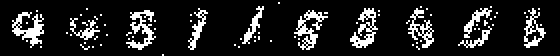

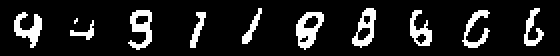

In [19]:
################################# Sample Output ##############################

import Distributions: Bernoulli, mode

# Sample from the learned model.
function model_sample_dist(; use_gpu=true)
    μ = zeros(Dz)
    logσ = zeros(Dz)
    if use_gpu
        μ = gpu(μ)
        logσ = gpu(logσ)
    end
    z′ = z(μ, logσ)
    x′ = f(z′)
    return Bernoulli.(cpu(x′))
end

img(x) = Gray.(reshape(x, 28, 28))

seed!(42)
image_samples = [model_sample_dist() for i = 1:10]
display(hcat(img.(map(x -> rand.(x), image_samples))...))
display(hcat(img.(map(x -> mode.(x), image_samples))...))